### Water persistence testing
- testing the improvements Gabrielle made to waterpersistence
- specifically similar to consecutive count at level rather than current implementation that just takes a wofs summary percentage

- use livingeath_lccs repo master branch, but modify to just perform a count of water persistence rather than current implementation of input data being in days (i.e. 1-365) then converting back to months
- also need to think about doing the same for water seasonality
- implementation should be as below

```        
self.output_codes_descriptions = { 1 : ("B1", "Perennial (> 9 months)"),
                                   7 : ("B7", "Non-perennial (7 to 9 months)"),
                                   8 : ("B8", "Non-perennial (4 to 6 months)"),
                                   9 : ("B9", "Non-perennial (1 to 3 months)")}
# In days. Use months multiplied by 30 to simplify
self.class_boundaries = {1 : (9, None),
                         7 : (7, 9),
                         8 : (4, 7),
                         9 : (1, 4),
                         0 : (0, 1)}
self.valid_level3_classes = [220, 227, 228]
# Set valid level 4 classes.
self.valid_level4_layers_filters = ["(waterstt_wat_cat_l4a == 1)"]
```
- use water_pers branch on australia repo (actually doesn't matter)

In [1]:
import argparse
import logging
import os, sys, glob
import yaml
import copy

import numpy as np
import xarray as xr
from itertools import groupby

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
dc = datacube.Datacube()

sys.path.append("/home/jovyan/development/livingearth_australia")
sys.path.append(os.path.abspath("/home/jovyan/development/livingearth_lccs"))
sys.path.append(os.path.abspath("/home/jovyan/development/livingearth_australia/le_plugins"))
sys.path.append("/home/jovyan/development/dea-notebooks/Scripts")
os.environ["LE_LCCS_PLUGINS_PATH"] = "/home/jovyan/development/livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs import le_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
yaml_sites_file = os.path.abspath("/home/jovyan/development/chris_leaust_testing/notebooks/misc/au_test_sites.yaml")
config_file = os.path.abspath("/home/jovyan/development/livingearth_australia/templates/l3_vp_template.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Coorong"

extent = [site_config[site_name]["min_x"],
          site_config[site_name]["min_y"],
          site_config[site_name]["max_x"],
          site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-100, 100)
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':(extent[0],extent[2]),
            'y':(extent[1],extent[3]),
            'crs':crs,
            'resolution':res})

In [3]:
# Read in config file
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

# Set up dictionary to define size parameters
target_size = {}
# If an extent is provided then use this instead of the values
# in the config file
if extent is not None:
    if not isinstance(extent, list) or len(extent) != 4:
        raise TypeError("Extent must be a list with 4 values")

    else:
        target_size["target_min_x"] = extent[0]
        target_size["target_max_x"] = extent[2] - 1000
        target_size["target_min_y"] = extent[1]
        target_size["target_max_y"] = extent[3] - 1000
else:
    target_size["target_min_x"] = config["extent"]["min_x"]
    target_size["target_max_x"] = config["extent"]["max_x"]
    target_size["target_min_y"] = config["extent"]["min_y"]
    target_size["target_max_y"] = config["extent"]["max_y"]

target_size["target_pixel_size_x"] = res[1]
target_size["target_pixel_size_y"] = res[0]

target_size["target_crs"] = crs

# Set up list of input layers to read in
# Try to read all level 3 layers
try:
    input_layers = config["L3layers"]
# If no 'L3layers' defined in the config file
# try 'Layers' (format used for older Level3 only config files)
except KeyError:
    input_layers = config["Layers"]

# Read each into xarray and save to list
logging.info("Reading in data")
variables_xarray_list = []

layer_names = []
for var_name, ingest_parameters in input_layers.items():
    # Don't run any of the 'xarray_maths' classes yet - nead to load all other variables first
    print("Loading: {}".format(var_name))
    import_class_name = ingest_parameters["ingest_class"]
        # Get the class to use for importing
    if import_class_name != "xarray_maths":
        import_class = getattr(getattr(le_ingest, import_class_name.split(".")[0]),
                              import_class_name.split(".")[1])
        # Set up instance of import class
        import_obj = import_class(**target_size)

        # Import
        ingest_parameters["variable_name"] = var_name
        variables_xarray = import_obj.read_to_xarray(**ingest_parameters)
        variables_xarray_list.append(variables_xarray)
        layer_names.append(var_name)

# Merge to a single dataset
classification_data = xr.merge(variables_xarray_list)

# Apply band maths (if any)
logging.info("  Applying band maths")
for var_name, ingest_parameters in input_layers.items():
    import_class_name = ingest_parameters["ingest_class"]
    if import_class_name == "xarray_maths":
        # Set up instance of import class
        variables_xarray_list.append(le_ingest.ingest_base.LEIngest().xarray_maths(
            classification_data, var_name, layer_names,
            ingest_parameters["expstr"]))

# Make new stack with additional layers
classification_data = xr.merge(variables_xarray_list)

# Get dimensions (tuple)
classification_dims = classification_data["vegetat_veg_cat"].dims

# Apply Level 3 classification
logging.info("Applying Level 3 Classification")
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

# Get colour scheme
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3)

level3_out_xarray = xr.Dataset(
    {"level1" : (classification_dims, level1),
     "level2" : (classification_dims, level2),
     "level3" : (classification_dims, level3),
     "Red" : (classification_dims, red),
     "Green" : (classification_dims, green),
     "Blue" : (classification_dims, blue)},
    coords=classification_data.coords)

# get water mask
water_mask_level3 = level3_out_xarray.level3 == 220

Loading: fc_veg


/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Loading: saltpan_mask
Loading: mudflat_mask
Loading: DEM
Loading: vegetat_veg_cat
Loading: wofs_mask
Loading: item_v2_mask
Loading: mangrove
Loading: aquatic_wat_cat
Loading: cultman_agr_cat


/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid resu

Loading: tf_urban_classification
Loading: mads_urban_mask_sdev
Loading: mads_urban_mask_edev
Loading: wcf_mask


/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading: artific_urb_cat


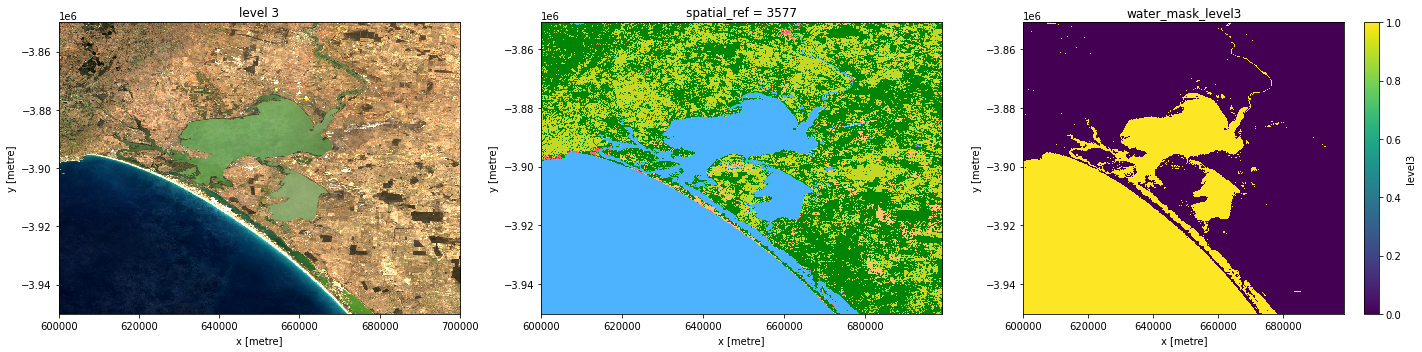

In [4]:
# Load geomedian
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')

plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,3)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax1.set_title('level 3')

ax3=plt.subplot(gs[0,2])
water_mask_level3.plot.imshow()
ax3.set_title('water_mask_level3')

plt.tight_layout()
plt.show()

In [5]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file('/home/jovyan/development/chris_leaust_testing/notebooks/misc/virtual_product_cat.yaml')

In [6]:
# load data need from virtual product and make/compare both current and gabrielles implementations (1. FCcc and FCcc with oneobs)

#### current implementation (wofs summary and % just go into categories)

```
self.output_codes_descriptions = { 1 : ("B1", "Perennial (> 9 months)"),
                                   7 : ("B7", "Non-perennial (7 to 9 months)"),
                                   8 : ("B8", "Non-perennial (4 to 6 months)"),
                                   9 : ("B9", "Non-perennial (1 to 3 months)")}
# In days. Use months multiplied by 30 to simplify
self.class_boundaries = {1 : (9*30, None),
                         7 : (7*30, 9*30),
                         8 : (4*30, 7*30),
                         9 : (1*30, 4*30),
                         0 : (0*30, 1*30)}
```

In [7]:
# load wofs_annual_summary from vp
product = catalog['wofs_annual_summary']
wofs_annual_summary = product.load(dc, **query)

In [8]:
waterper = wofs_annual_summary['frequency'].squeeze().drop('time')
# get data  values of waterper at level 4, masking out zero values
waterper_mask = waterper * water_mask_level3
waterper_mask = waterper_mask.where(waterper_mask > 0)

# make copy of zero values then fill with days (i.e. 1-365)
water_per_days = np.zeros_like(waterper_mask, dtype='float64')
water_per_days = np.where((waterper_mask > 0) & (waterper_mask <= 1), waterper_mask*12*30, water_per_days)
water_per_days_arr = xr.DataArray(water_per_days, coords={'y': waterper_mask['y'].values, 'x': waterper_mask['x'].values}, dims=['y', 'x'])

In [9]:
# make copy of zero values then fill with categorical water persistence values
water_per_percentage = copy.deepcopy(water_per_days_arr)
water_per_percentage.values = np.zeros_like(water_per_percentage, dtype='float64')

# make 4 groups based on days values as per current implementation
water_per_percentage.values = np.where(((water_per_days_arr > 0*30) & (water_per_days_arr < 1*30)), 0, water_per_percentage.values)
water_per_percentage.values = np.where(((water_per_days_arr >= 1*30) & (water_per_days_arr < 4*30)), 9, water_per_percentage.values)
water_per_percentage.values = np.where(((water_per_days_arr >= 4*30) & (water_per_days_arr < 7*30)), 8, water_per_percentage.values)
water_per_percentage.values = np.where(((water_per_days_arr >= 7*30) & (water_per_days_arr < 9*30)), 7, water_per_percentage.values)
water_per_percentage.values = np.where(((water_per_days_arr >= 9*30) & (water_per_days_arr <= 12*30)), 1, water_per_percentage.values)

In [10]:
### colour up as per golden_dark scheme
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0,0.5,1.5,7.5,8.5,9.5],['#FFFFFF','#3887B8','#5CA2CC','#82BEE2','#ABDDFB'])

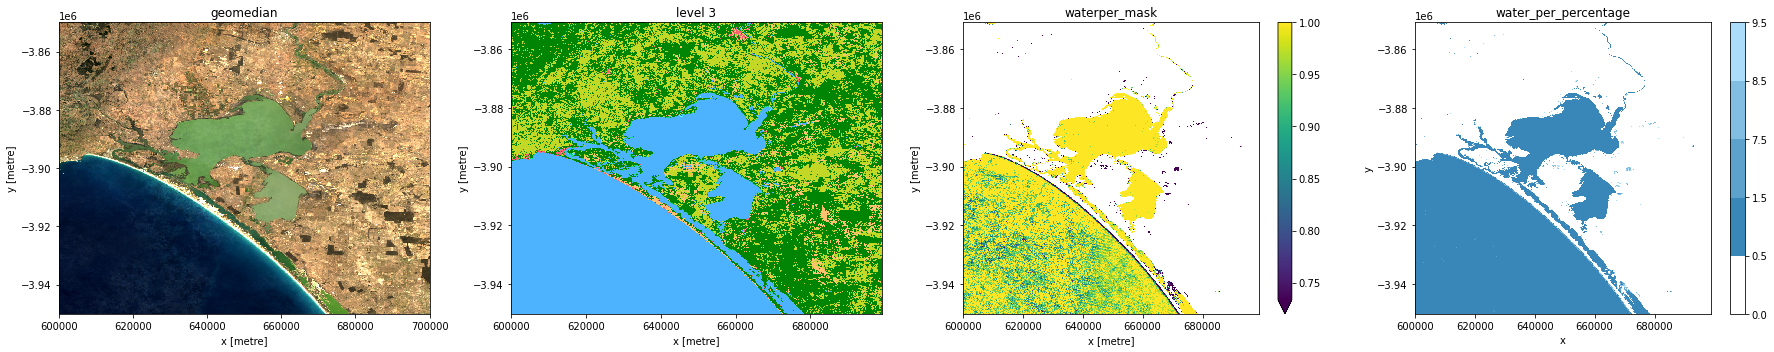

In [11]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
waterper_mask.plot.imshow(robust=True)
ax3.set_title('waterper_mask')

ax4=plt.subplot(gs[0,3])
water_per_percentage.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('water_per_percentage')

plt.tight_layout()
plt.show()

#### consecutive count implementation (similar to FC_summary on master)

In [12]:
# load wofs_daily from vp (no masking applied here, just raw wofs, so no nans at present)
product = catalog['wofs_daily']
data = product.load(dc, **query)

In [13]:
def consecutive_count_water(water_numpy, consecutive_numpy, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z, y, x]
    :param numpy.array consecutive_numpy: Bool output array for water (1) and not water (0)
    :param float consec_msk_val: What value to calculcate consectutives on
                                 Default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:, y, x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            else:
                consecutive_numpy[y,x] = max(counts)

    return consecutive_numpy


In [14]:
# Select clear and water pixels - binary (128: clear and wet, 132: clear, wet & sea 0: clear)
water = ((data.water == 128) | (data.water == 132)).to_dataset()
clear = ((data.water == 128) | (data.water == 132) | (data.water == 0)).to_dataset()
# pull out the sea in particular as going to use this as a mask to force into always > 9 months a year (sorts out issues with reduced observation count)
sea = (data.water == 132).to_dataset()

# Group by month - total number of observations
water_month = water.groupby('time.month').sum(dim='time')   
clear_month = clear.groupby('time.month').sum(dim='time') 
sea_month = sea.groupby('time.month').sum(dim='time') 

# Calculate frequency of water observations within the month
freq = water_month/clear_month

# Threshold frequency in month to get water or not
# Values greater than 0.5 kept
water_dominant = freq['water'] > 0.5
# Converted to binary
water_mask = water_dominant.where(freq['water'] >= 0)

# Make values of > 0.5 == 1 (end result in binary water mask)
water_mask_drop = np.where(water_mask > 0.5, 1, water_mask)
water_mask_xr = xr.DataArray(water_mask_drop, coords=water_mask.coords, dims=water_mask.dims)

# Pull water as numpy array
water_numpy = water_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((water_numpy.shape[1], water_numpy.shape[2]), dtype=np.float32)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count_water(water_numpy, consecutive_numpy)

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
water_reduce = water_mask.max(dim='month')

# also reducing sea here to use as a mask to force sea into > 9 months despite observation count
sea_reduce = sea_month.max(dim='month')
sea_mask = (sea_reduce > 0)
sea_mask = sea_mask.water
# make copy of zero values then make boolean mask (12 == sea, 9 == all else) to add to water_summary
sea_mask_bool = copy.deepcopy(sea_mask)
sea_mask_bool.values = np.zeros_like(sea_mask, dtype='float32')
sea_mask_bool.values = np.where((sea_mask == 0), 0, sea_mask_bool.values)
sea_mask_bool.values = np.where((sea_mask == 1), 12, sea_mask_bool.values)

# create new data array with same dimensions as original (output is 0-12 giving max consecutive counts)
water_summary = xr.DataArray(consecutive_numpy, coords=water_reduce.coords, dims=water_reduce.dims)  
# add sea_mask_bool to make sure sea is forced to > 9 months a year
water_summary_sea_mask = water_summary + sea_mask_bool

# make copy of zero values then fill with categorical water persistence values
water_per_consecutive = copy.deepcopy(water_summary_sea_mask)
water_per_consecutive.values = np.zeros_like(water_summary_sea_mask, dtype='float64')

# make 4 groups based on days values as per current implementation
water_per_consecutive.values = np.where(((water_summary_sea_mask > 0) & (water_summary_sea_mask < 1)), 0, water_per_consecutive.values)
water_per_consecutive.values = np.where(((water_summary_sea_mask >= 1) & (water_summary_sea_mask < 4)), 9, water_per_consecutive.values)
water_per_consecutive.values = np.where(((water_summary_sea_mask >= 4) & (water_summary_sea_mask < 7)), 8, water_per_consecutive.values)
water_per_consecutive.values = np.where(((water_summary_sea_mask >= 7) & (water_summary_sea_mask < 9)), 7, water_per_consecutive.values)
water_per_consecutive.values = np.where((water_summary_sea_mask >= 9), 1, water_per_consecutive.values)

water_per_consecutive_mask = water_per_consecutive * water_mask_level3
water_per_consecutive_mask_out = water_per_consecutive_mask.where(water_per_consecutive_mask > 0)

In [15]:
### colour up as per golden_dark scheme
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0,0.5,1.5,7.5,8.5,9.5],['#FFFFFF','#3887B8','#5CA2CC','#82BEE2','#ABDDFB'])

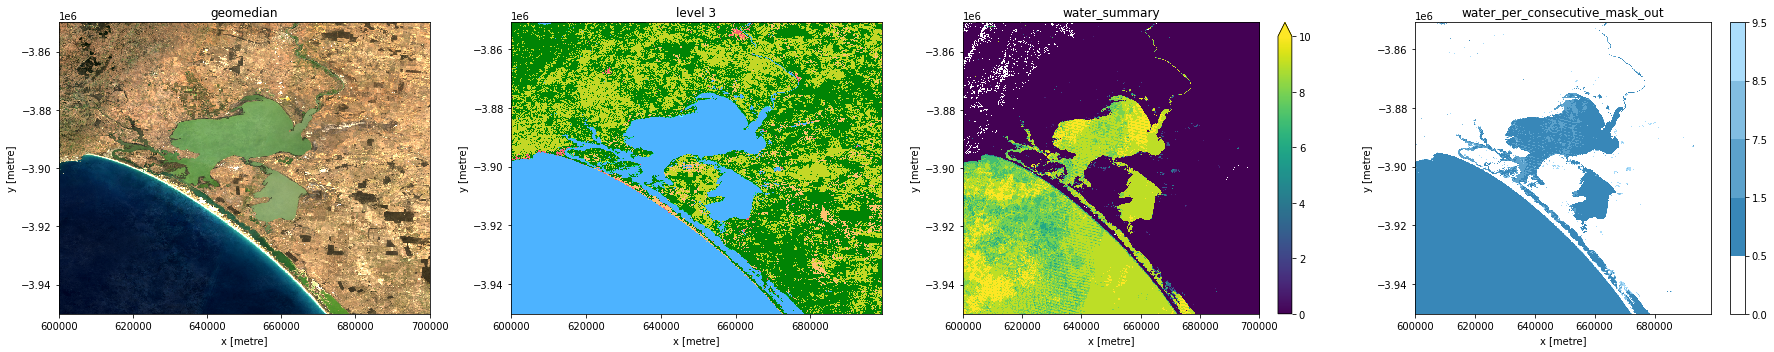

In [16]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
water_summary.plot.imshow(robust=True)
ax3.set_title('water_summary')

ax4=plt.subplot(gs[0,3])
water_per_consecutive_mask_out.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('water_per_consecutive_mask_out')

plt.tight_layout()
plt.show()

#### consecutive count implementation (normalise on number of months observations)
- prev count without normalising requiring a sea mask, however no necessary here as all sea obs are water and hence when normalised are just always water

In [17]:
# load wofs_daily from vp (no masking applied here, just raw wofs, so no nans at present)
product = catalog['wofs_daily']
data = product.load(dc, **query)

In [18]:
def consecutive_count_water(water_numpy, consecutive_numpy, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series
    and normalise based on number of observed months

    :param numpy.array water_numpy: 3-D array of tv[z, y, x]
    :param numpy.array consecutive_numpy: Bool output array for water (1) and not water (0)
    :param float consec_msk_val: What value to calculcate consectutives on
                                 Default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:, y, x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            # returns an array with consecutive counts of 1's
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]
        
            # Get counts of valid months observations (i.e. just 0's or 1's)
            # returns an array with consecutive counts of 0's or 1's
            obs_counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label >= 0]
            
            # if counts is empty array, output 0
            if not counts:
                consecutive_numpy[y,x] = 0

            # if counts is not empty array, give the max consecutive counts of 1's,
            # divided by sum of obs_counts (i.e. number of months of observations),
            # multipled by 12 (to get value as how many months)
            else:
                consecutive_numpy[y,x] = (max(counts) / sum(obs_counts))*12

    return consecutive_numpy

In [19]:
# Select clear and water pixels - binary (128: clear and wet, 132: clear, wet & sea 0: clear)
water = ((data.water == 128) | (data.water == 132)).to_dataset()
clear = ((data.water == 128) | (data.water == 132) | (data.water == 0)).to_dataset()

# Group by month - total number of observations
water_month = water.groupby('time.month').sum(dim='time')   
clear_month = clear.groupby('time.month').sum(dim='time') 

# Calculate frequency of water observations within the month
freq = water_month/clear_month

# Threshold frequency in month to get water or not
# Values greater than 0.5 kept
water_dominant = freq['water'] > 0.5
# Converted to binary
water_mask = water_dominant.where(freq['water'] >= 0)

# Make values of > 0.5 == 1 (end result in binary water mask)
water_mask_drop = np.where(water_mask > 0.5, 1, water_mask)
water_mask_xr = xr.DataArray(water_mask_drop, coords=water_mask.coords, dims=water_mask.dims)

# Pull water as numpy array
water_numpy = water_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((water_numpy.shape[1], water_numpy.shape[2]), dtype=np.float32)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count_water(water_numpy, consecutive_numpy)

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
water_reduce = water_mask.max(dim='month')

# create new data array with same dimensions as original (output is 0-12 giving max consecutive counts)
water_summary = xr.DataArray(consecutive_numpy, coords=water_reduce.coords, dims=water_reduce.dims)  

# make copy of zero values then fill with categorical water persistence values
water_per_consecutive = copy.deepcopy(water_summary)
water_per_consecutive.values = np.zeros_like(water_summary, dtype='float64')

# make 4 groups based on days values as per current implementation
water_per_consecutive.values = np.where(((water_summary > 0) & (water_summary < 1)), 0, water_per_consecutive.values)
water_per_consecutive.values = np.where(((water_summary >= 1) & (water_summary < 4)), 9, water_per_consecutive.values)
water_per_consecutive.values = np.where(((water_summary >= 4) & (water_summary < 7)), 8, water_per_consecutive.values)
water_per_consecutive.values = np.where(((water_summary >= 7) & (water_summary < 9)), 7, water_per_consecutive.values)
water_per_consecutive.values = np.where((water_summary >= 9), 1, water_per_consecutive.values)

water_per_consecutive_mask = water_per_consecutive * water_mask_level3
water_per_consecutive_normalised = water_per_consecutive_mask.where(water_per_consecutive_mask > 0)

In [20]:
### colour up as per golden_dark scheme
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0,0.5,1.5,7.5,8.5,9.5],['#FFFFFF','#3887B8','#5CA2CC','#82BEE2','#ABDDFB'])

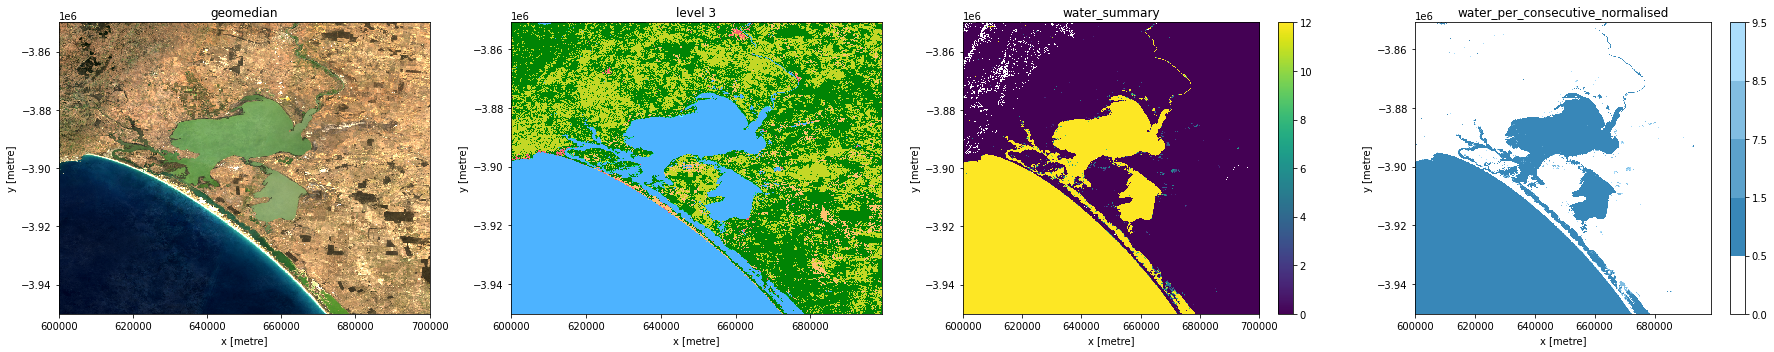

In [21]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
water_summary.plot.imshow(robust=True)
ax3.set_title('water_summary')

ax4=plt.subplot(gs[0,3])
water_per_consecutive_normalised.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('water_per_consecutive_normalised')

plt.tight_layout()
plt.show()

#### Comparing methods

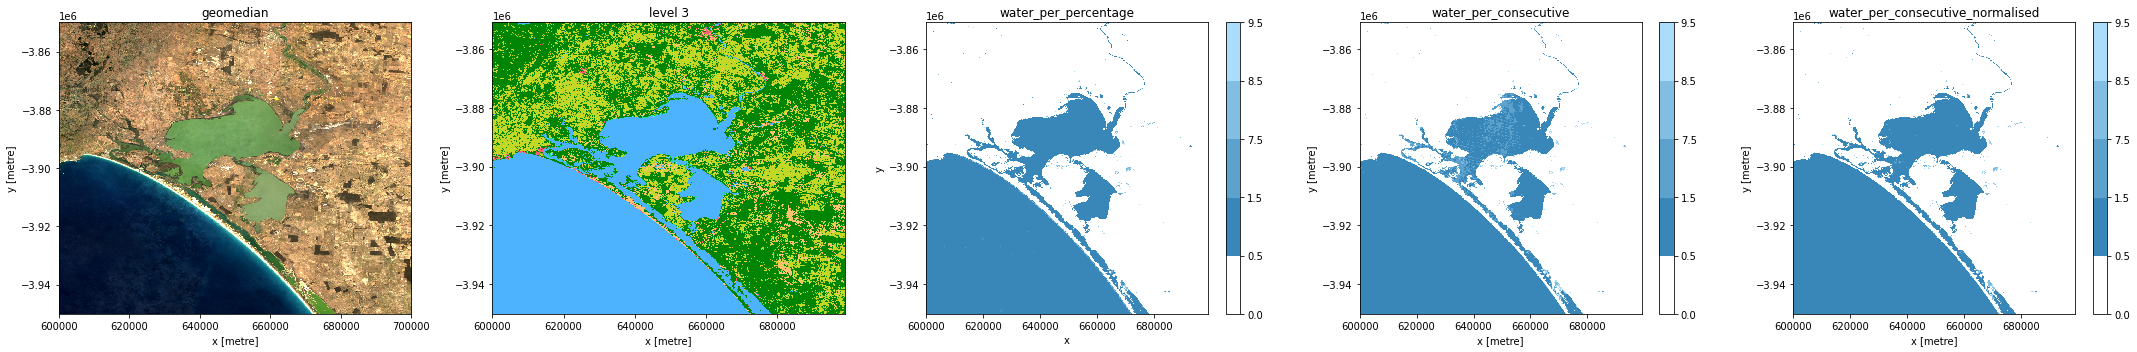

In [22]:
# all sites comparison
plt.figure(figsize=(30,5))
gs = gridspec.GridSpec(1,5)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
water_per_percentage.plot.imshow(cmap=cmap, norm=norm)
ax3.set_title('water_per_percentage')

ax4=plt.subplot(gs[0,3])
water_per_consecutive_mask_out.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('water_per_consecutive')

ax5=plt.subplot(gs[0,4])
water_per_consecutive_normalised.plot.imshow(cmap=cmap, norm=norm)
ax5.set_title('water_per_consecutive_normalised')

plt.tight_layout()
plt.show()